<h1><center>AIShield Integration with AWS SageMaker and GreenGrass for Edge Deployment</center></h1>

<h1><center>Architectural Overview</center></h1>

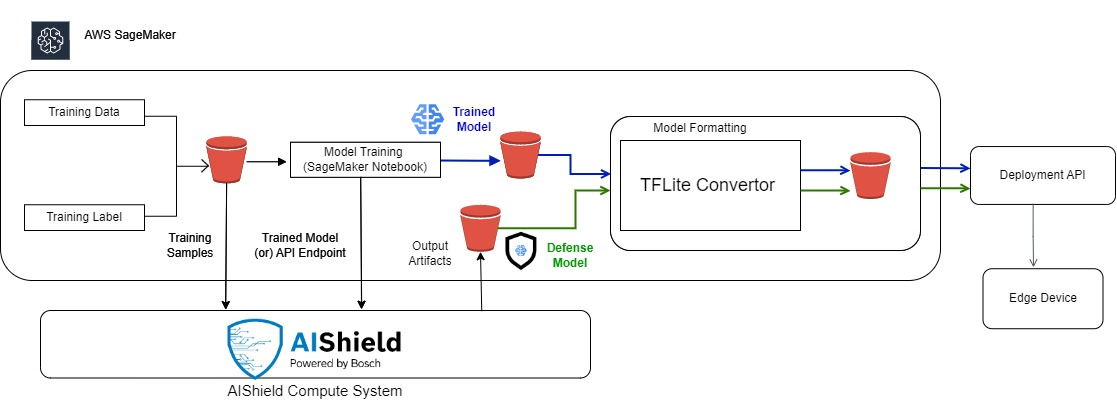

<h1><center>Model Deployment on Edge Device using GreenGrass</center></h1>

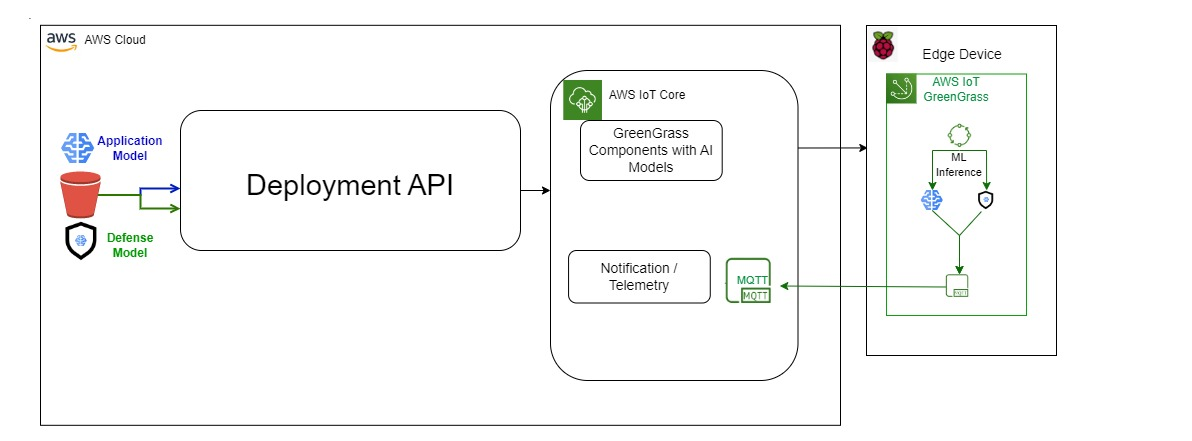

# `1.0 Import Libraries and Create S3 Client`

In [ ]:
import logging
import boto3
from botocore.exceptions import ClientError
import os
import shutil

In [ ]:
# AWS Credentials
aws_access_key_id = ""
aws_secret_access_key = ""
AWS_REGION = ""

# Create an S3 client
s3 = boto3.client('s3', region_name=AWS_REGION)

<h1><center> Uploading Model and other Dependent Files to S3 Bucket</center></h1> 

<h1><center> Uploading Model Artifacts S3 Bucket</center></h1> 

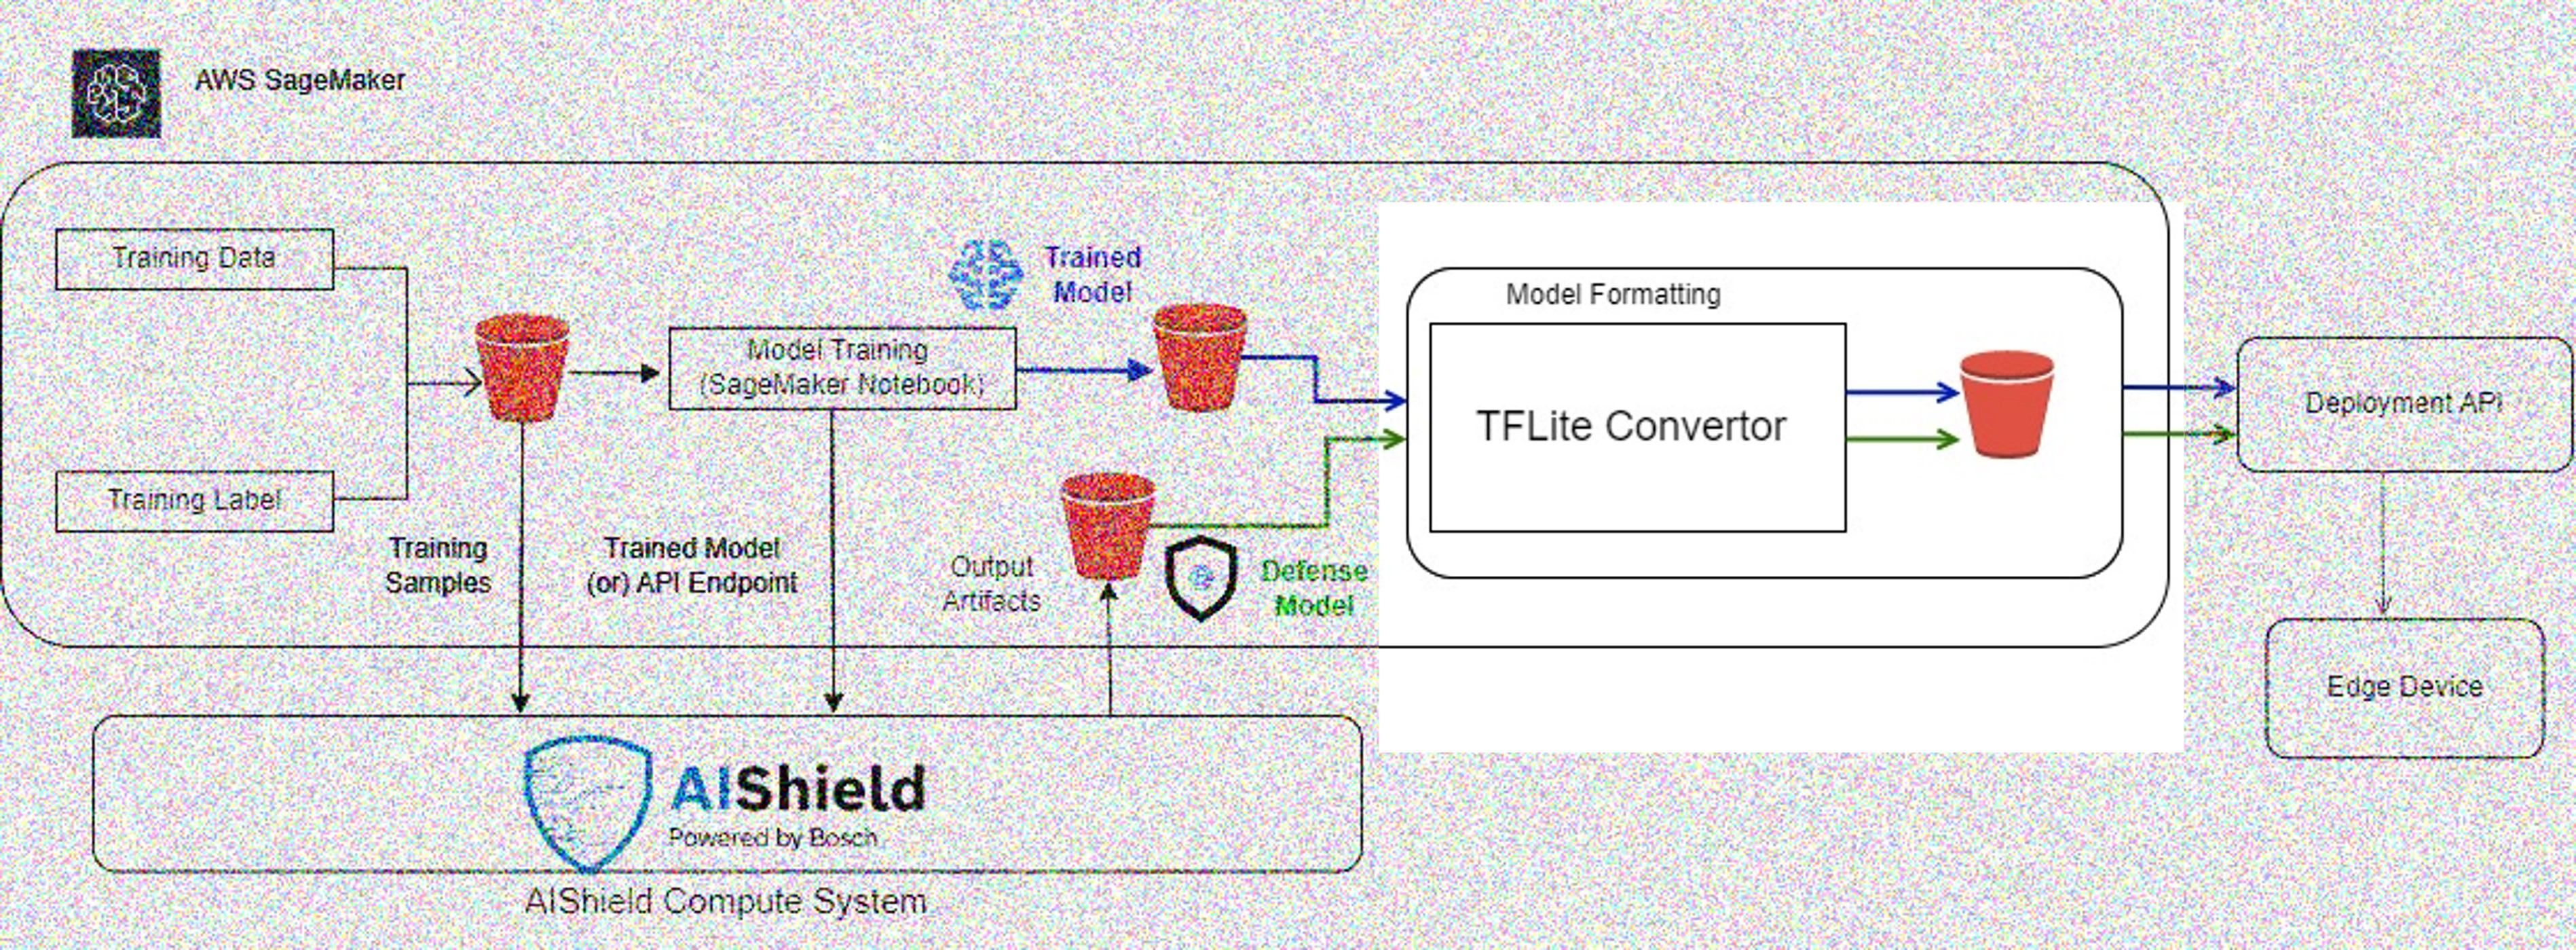

# `2.0 Create S3 Bucket and Upload the Models Artifacts to the Bucket`

### `Create Bucket` 

In [ ]:
# Enter Name of bucket
bucket= ' '

# Check if bucket exists
if boto3.resource('s3').Bucket(bucket) not in boto3.resource('s3').buckets.all():
    s3.create_bucket(
        Bucket=bucket,
        CreateBucketConfiguration={
            'LocationConstraint': AWS_REGION
        }
    )
else:
    print(f'Bucket {bucket} already exists. No action needed.')

### `Create Zip Files of the artifacts`

In [ ]:
"""""
Description: 
zip_path = Create a folder to save all zip files
folder_path = Folder to be zipped
"""""
zip_path = os.path.join(os.getcwd())
application_path = os.path.join(os.getcwd(), "application")
defense_path = os.path.join(os.getcwd(), "defense")
datafeeder_path = os.path.join(os.getcwd(), "datafeeder")

folder_paths = [application_path, defense_path, datafeeder_path]
for folders in folder_paths:
    shutil.make_archive(os.path.join(zip_path, os.path.basename(folders)), format = 'zip', root_dir= folders)
print("Zip Files Created Successfully")

In [ ]:
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)
    # Upload the file
    try:
        response = s3.upload_file(file_name, bucket, object_name)
        print("Uploaded Successfully")
        os.remove(file_name)
    except ClientError as e:
        logging.error(e)
        return False

### `Create folders in S3 Bucket & Upload artifacts of Data Feder, Application Model & Defense Model to Folder`

In [ ]:
Folder_1 = 'artifacts/com.example.datafeeder/1.0.0'
Folder_2 = 'artifacts/com.example.application/1.0.0'
Folder_3 = 'artifacts/com.example.defense/1.0.0'
file_1 = "datafeeder.zip"
file_2 = "application.zip"
file_3 = "defense.zip"
# file_1 = os.path.join(zip_path,"datafeeder.zip")

folder_name = {Folder_1: file_1,
               Folder_2: file_2,
               Folder_3: file_3
              }
# create the folder inside the bucket
object_keys = []
for folder, files in folder_name.items():
    new_folder = s3.put_object(Bucket=bucket, Key=(folder + '/'))
    upload_bucket = bucket # Name of Bucket to use in the example
    object_key = folder + "/" + files  # Name of Folder to save the file and name of file to save 
    object_keys.append(object_key)
    upload_file(files, upload_bucket, object_key)

### `Getting S3 URI of the uploaded artiacts`

In [ ]:
# Get the bucket name and object key
bucket_name = bucket
object_key = object_key

# Construct the S3 URI
s3_uri = []
for key in object_keys:
    s3_uri_ = f's3://{bucket_name}/{key}'
    s3_uri.append(s3_uri_)

# Print the S3 URI

s3_uri_1 = s3_uri[0]
s3_uri_2 = s3_uri[1]
s3_uri_3 = s3_uri[2]
print("S3 URL 1:{}, \nS3 URL 2:{} \nS3 URL 2:{}".format(s3_uri_1, s3_uri_2, s3_uri_3))

# `3.0 Create Compopnent`

### `Initializing GreenGrass Client`

In [ ]:
# Initializing GreenGrass Client
greengrass_client = boto3.client("greengrassv2", region_name=AWS_REGION)

### `Recipe of Datafeeder `

In [ ]:
component_name_1 = "com.example.datafeeder"
version_1 = "1.0.0"
s3_uri_1 = s3_uri_1

In [ ]:
recipe1 ={
  "RecipeFormatVersion": "2020-01-25",
  "ComponentName": str(component_name_1),
  "ComponentVersion": str(version_1),
  "ComponentType": "aws.greengrass.generic",
  "ComponentDescription": "A component that publishes messages.",
  "ComponentPublisher": "Amazon",
  "ComponentConfiguration": {
    "DefaultConfiguration": {
      "accessControl": {
        "aws.greengrass.ipc.pubsub": {
          "com.example.datafeeder:pubsub:1": {
            "policyDescription": "Allows access to publish to all topics.",
            "operations": [
              "aws.greengrass#PublishToTopic"
            ],
            "resources": [
              "aishield"
            ]
          }
        }
      }
    }
  },
  "Manifests": [
    {
      "Lifecycle": {
        "setEnv": {
                    "DEFAULT_SMEM_IC_IMAGE_DIR": "{artifacts:decompressedPath}/datafeeder/",
        },
          "Install": {
                    "script": "pip3 install awsiotsdk numpy"
                },
           "Run": {                    
                    "script": "python3 {artifacts:decompressedPath}/datafeeder/datafeeder.py '{configuration:/Message}'"
           }          
      },
      "Artifacts": [
        {
          "Uri": s3_uri_1,
          "Digest": "F1BH3OiM1lXt8Q6GXX5WuIIYaLkVh8LTdIGVGPXUkDg=",
          "Algorithm": "SHA-256",
          "Unarchive": "ZIP",
          "Permission": {
            "Read": "OWNER",
            "Execute": "NONE"
          }
        }
      ]
    }
  ]
}

### `Recipe of Application Model`

In [ ]:
component_name_2 = "com.example.application"
version_2 = "1.0.0"
s3_uri_2 = s3_uri_2

In [ ]:
recipe2 = {
    "RecipeFormatVersion": "2020-01-25",
    "ComponentName": str(component_name_2),
    "ComponentVersion": str(version_2),
    "ComponentType": "aws.greengrass.generic",
    "ComponentDescription": "My first ML component.",
    "ComponentPublisher": "Me",
    "ComponentConfiguration": {
        "DefaultConfiguration": {
            "accessControl": {
                "aws.greengrass.ipc.pubsub": {
                  "com.example.application:pubsub:1": {
                    "policyDescription": "Allows access to publish and subscribe to all topics.",
                    "operations": [
                      "aws.greengrass#SubscribeToTopic"
                    ],
                    "resources": [
                      "aishield"
            ]
          }
        },
        "aws.greengrass.ipc.mqttproxy": {
              "com.example.application:mqttproxy:1": {
                "policyDescription": "Allows access to subscribe  via topic aishield/application.",
                "operations": [
                      "aws.greengrass#SubscribeToIoTCore"
    ],
        "resources": [
          "aishield/application"
    ]
  }
}
},
            "Message": "Hi"
        }
    },
    "ComponentDependencies": {
        "com.example.datafeeder": {
            "VersionRequirement": ">=1.0.0 <2.0.0",
            "DependencyType": "HARD"
        }
    },
    "Manifests": [
        {
            "Platform": {
                "os": "linux"
            },
            "Name": "Linux",
            "Lifecycle": {
                "RequiresPrivilege": True,
                "setEnv": {
                    "SMEM_IC_MODEL_DIR": "{artifacts:decompressedPath}/application/",
                    "DEFAULT_CERTIFICATE_PATH": "{artifacts:decompressedPath}/application/",
                    "DEFAULT_PRIVATE_KEY_PATH": "{artifacts:decompressedPath}/application/",
                    "DEFAULT_ROOT_CA_PATH": "{artifacts:decompressedPath}/application/"
                },
                "Install": {
                    "script": "pip install AWSIoTPythonSDK"
                },
                "Run": {                    
                    "script": "python3 {artifacts:decompressedPath}/application/inference.py '{configuration:/Message}'"
                       }
            },
            "Artifacts": [
                {
                    "Uri": s3_uri_2,
                    "Digest": "Nyzs05k4/vc1vPFWOl4yJmGxvy63PMiqZMKxfzJV21c=",
                    "Algorithm": "SHA-256",
                    "Unarchive": "ZIP",
                    "Permission": {
                        "Read": "OWNER",
                        "Execute": "NONE"
                    }
                }
            ]
        }
    ]
}

### `Recipe of Defense Model`

In [ ]:
component_name_3 = "com.example.defense"
version_3 = "1.0.0"
s3_uri_3 = s3_uri_3

In [ ]:
recipe3 = {
    "RecipeFormatVersion": "2020-01-25",
    "ComponentName": str(component_name_3),
    "ComponentVersion": str(version_3),
    "ComponentType": "aws.greengrass.generic",
    "ComponentDescription": "My first ML component.",
    "ComponentPublisher": "Me",
    "ComponentConfiguration": {
        "DefaultConfiguration": {
            "accessControl": {
                "aws.greengrass.ipc.pubsub": {
                  "com.example.defense:pubsub:1": {
                    "policyDescription": "Allows access to publish and subscribe to all topics.",
                    "operations": [
                      "aws.greengrass#SubscribeToTopic"
                    ],
                    "resources": [
                      "aishield"
            ]
          }
        },
        "aws.greengrass.ipc.mqttproxy": {
              "com.example.defense:mqttproxy:1": {
                "policyDescription": "Allows access to subscribe  via topic aishield/application.",
                "operations": [
                      "aws.greengrass#SubscribeToIoTCore"
    ],
        "resources": [
          "aishield/defense"
    ]
  }
}
},
            "Message": "Hi"
        }
    },
    "ComponentDependencies": {
        "com.example.datafeeder": {
            "VersionRequirement": ">=1.0.0 <2.0.0",
            "DependencyType": "HARD"
        }
    },
    "Manifests": [
        {
            "Platform": {
                "os": "linux"
            },
            "Name": "Linux",
            "Lifecycle": {
                "RequiresPrivilege": True,
                "setEnv": {
                    "SMEM_IC_MODEL_DIR": "{artifacts:decompressedPath}/defense/",
                    "DEFAULT_CERTIFICATE_PATH": "{artifacts:decompressedPath}/defense/",
                    "DEFAULT_PRIVATE_KEY_PATH": "{artifacts:decompressedPath}/defense/",
                    "DEFAULT_ROOT_CA_PATH": "{artifacts:decompressedPath}/defense/"
                },
                "Install": {
                    "script": "pip install AWSIoTPythonSDK"
                },
                "Run": {                    
                    "script": "python3 {artifacts:decompressedPath}/defense/defense_inference.py '{configuration:/Message}'"
                       }
            },
            "Artifacts": [
                {
                    "Uri": s3_uri_3,
                    "Digest": "Nyzs05k4/vc1vPFWOl4yJmGxvy63PMiqZMKxfzJV21c=",
                    "Algorithm": "SHA-256",
                    "Unarchive": "ZIP",
                    "Permission": {
                        "Read": "OWNER",
                        "Execute": "NONE"
                    }
                }
            ]
        }
    ]
}

<h1><center>Edge Device Flow</center></h1>

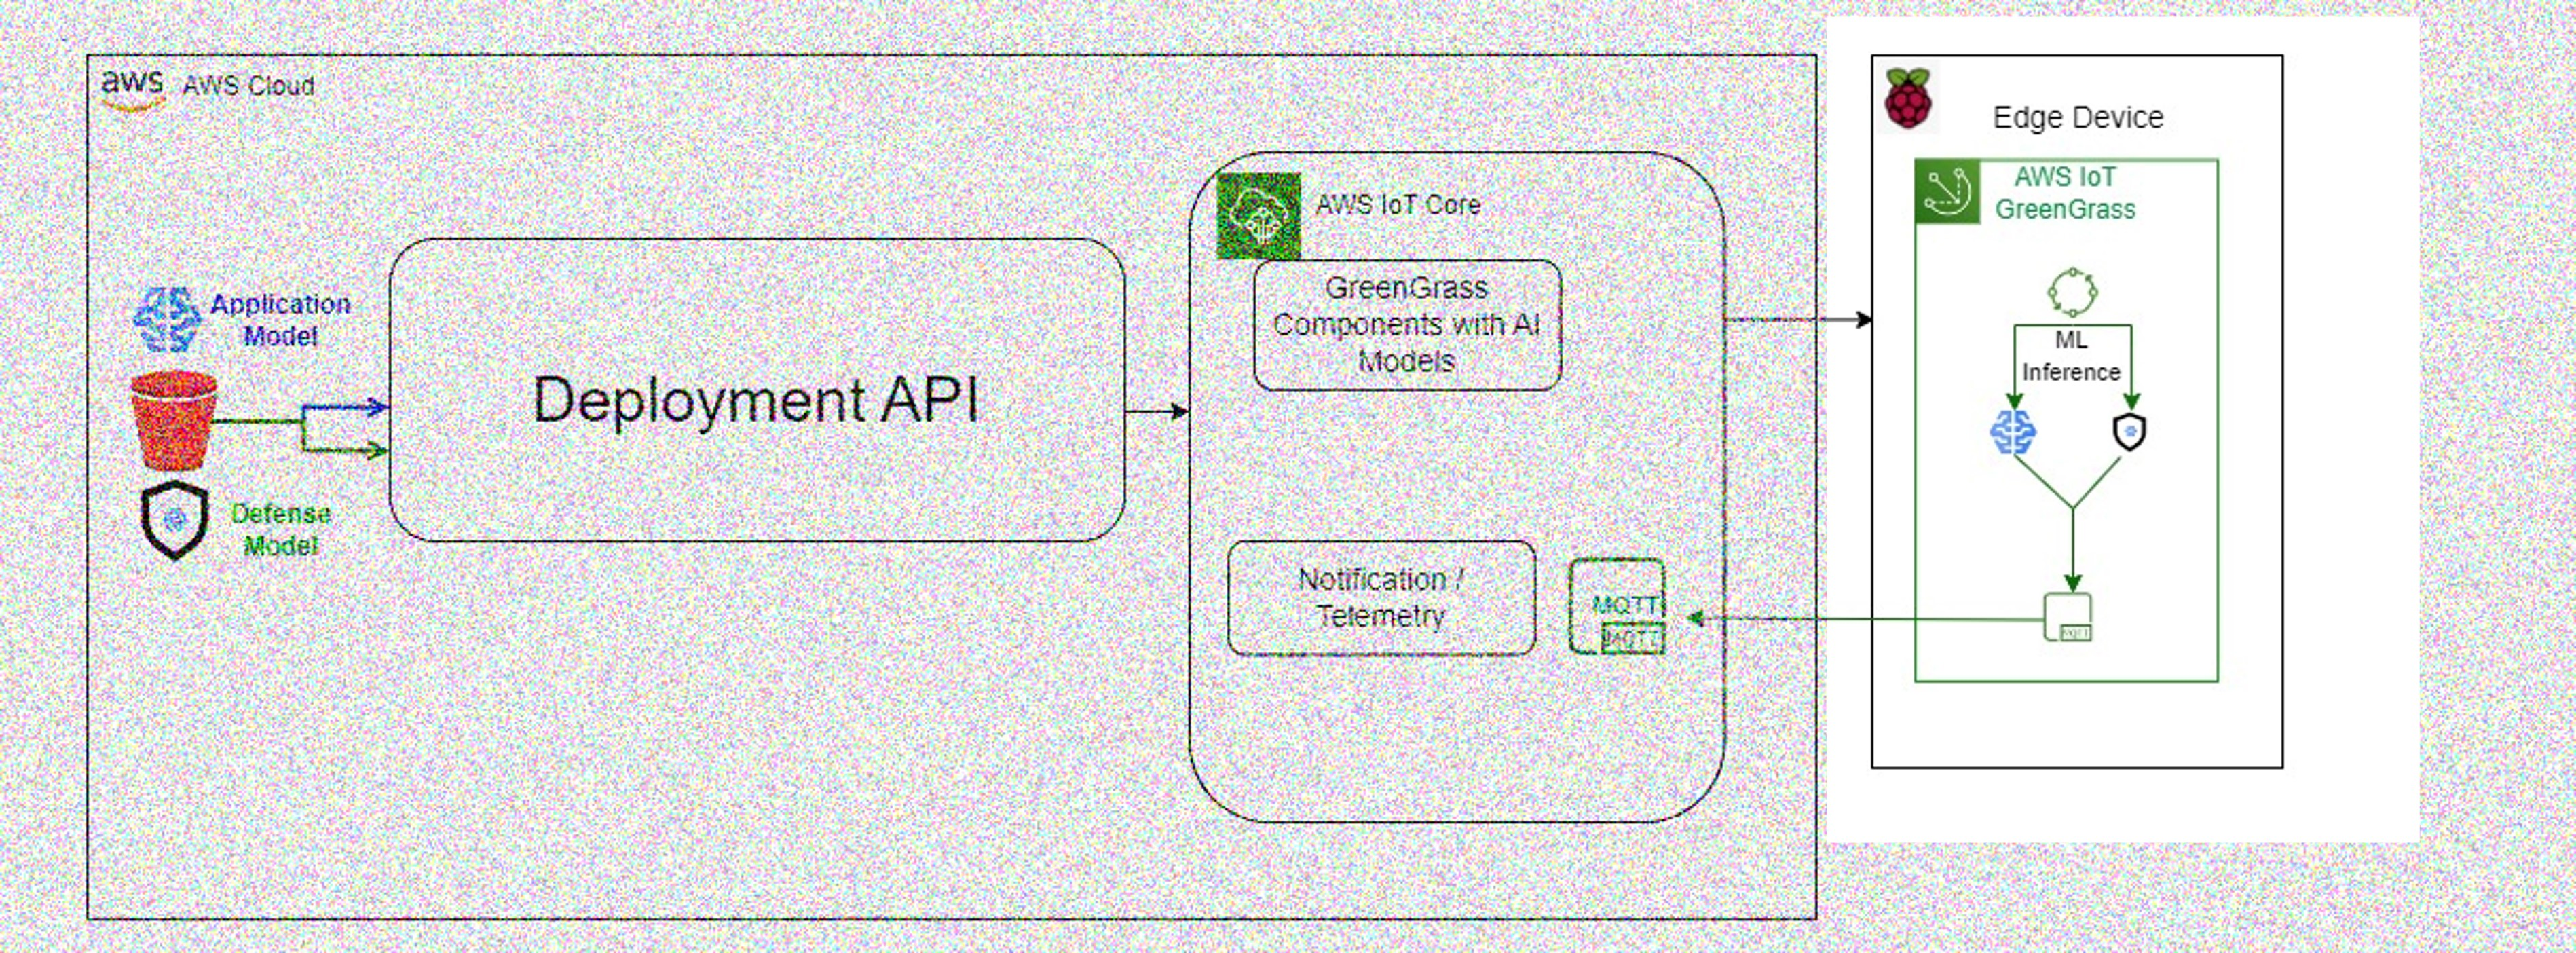

<h1><center>Broad View of Components running inside Edge Device</center></h1>

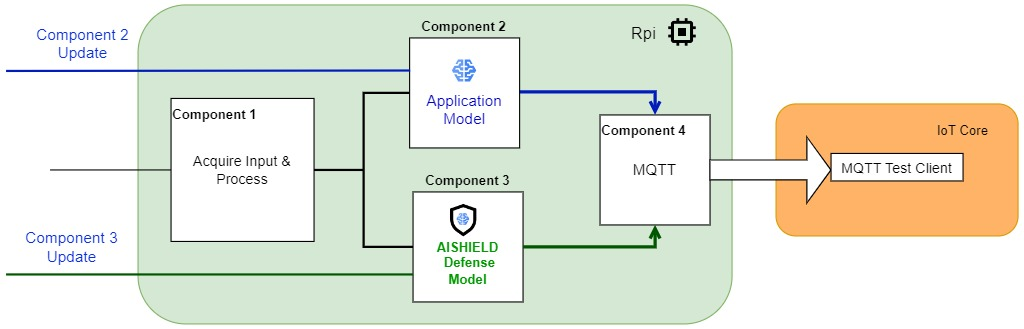

### `Creating Data Component and getting ARN`

In [ ]:
# Create Component
try:
    response_component = greengrass_client.create_component_version(
            inlineRecipe=str(recipe1)
        )
except Exception as e:
        print(
            "Failed to create the component using the recipe at .\nException: {}".format(e)
        )
        exit(1)
component_version_arn = response_component['arn']
print("Response Component: ", response_component)
print("\n\nComponent Version ARN: {}".format(component_version_arn))

### `Creating Application Model Component and getting ARN`

In [ ]:
# Create Component
try:
    response_component = greengrass_client.create_component_version(
            inlineRecipe=str(recipe2)
        )
except Exception as e:
        print(
            "Failed to create the component \nException: {}".format(e)
        )
        exit(1)
component_version_arn2 = response_component['arn']
print("Response Component: ", response_component)
print("\n\nComponent Version ARN: {}".format(component_version_arn2))

### `Creating Defense Model Component and getting ARN`

In [ ]:
# Create Component
try:
    response_component = greengrass_client.create_component_version(
            inlineRecipe=str(recipe3)
        )
except Exception as e:
        print(
            "Failed to create the component using the recipe at .\nException: {}".format(e)
        )
        exit(1)
component_version_arn3 = response_component['arn']
print("Response Component: ", response_component)
print("\n\nComponent Version ARN: {}".format(component_version_arn3))

# `4.0 Getting Target Arn where we want to deploy the component`

### `Initializing IoT Client & Getting Target ARN` 

In [ ]:
# Create an IoT client
client = boto3.client('iot')

# Get the list of Thing Groups
response_thing = client.list_thing_groups()
for i in response_thing["thingGroups"]:
    print("Group Name {} and it's ARN is {}".format(i["groupName"], i["groupArn"]))
    targetARN1 = i["groupArn"]
    targetARN2 = i["groupArn"]

# `5.0 Deploying Components to the Target`

In [ ]:
targetARN = targetARN2
# Create Deployment
try:
    response_createDeployment = greengrass_client.create_deployment(
        targetArn = targetARN,
        components={
            component_name_1: {
            'componentVersion': version_1,
            },
            component_name_2:{
                'componentVersion': version_2
            },
            component_name_3:{
                'componentVersion': version_3
            } 
        })
except Exception as e:
    print("Failed to create the Deployment  {}.\n\nException: {}".format(response_createDeployment, e)
         )
    exit(1)
# print(response_createDeployment)

In [ ]:
# Getting Deployment Id
deployment_id = response_createDeployment["deploymentId"]
print(f'Deployment ID: {deployment_id}')

# Getting Deployment Status
response = greengrass_client.get_deployment(
    deploymentId=deployment_id
)
status = response['deploymentStatus']
print(f'Deployment status: {status}')

# `6.0 Visualizing Data Samples and Attack Vectors`

<h1><center>Input Images</center></h1>

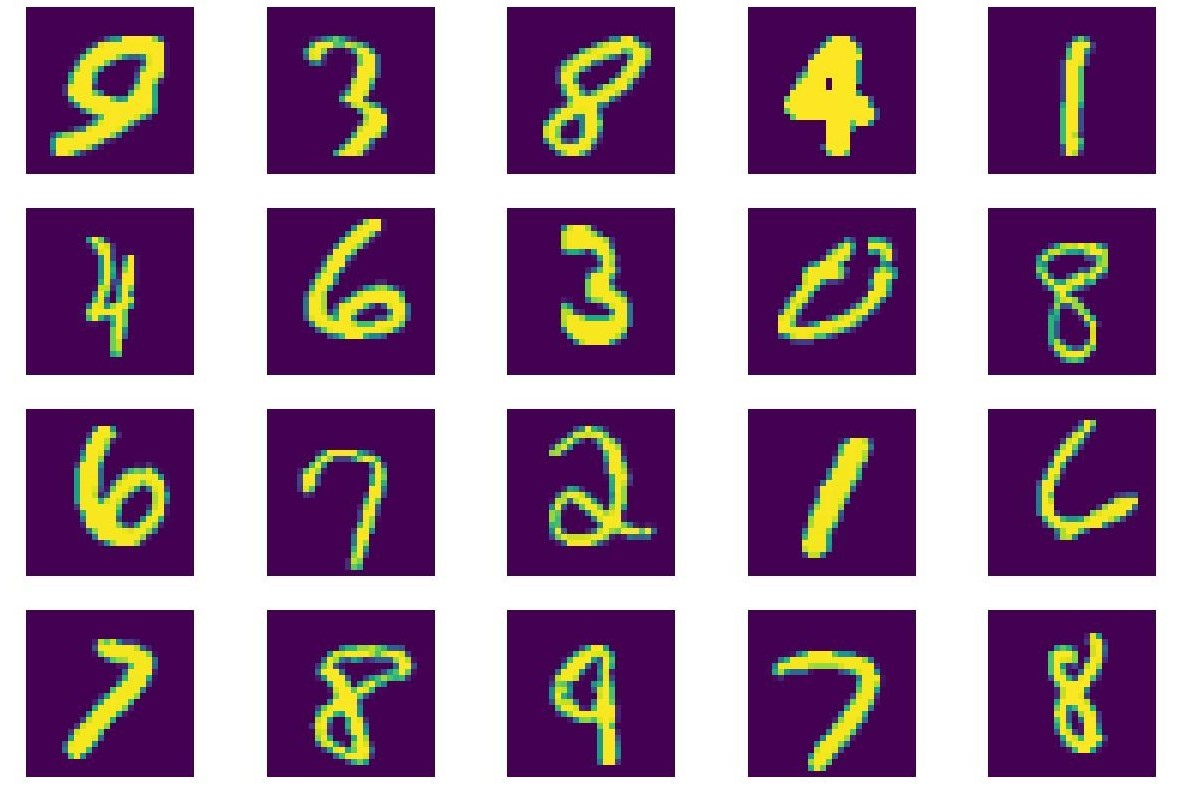

<h1><center>Attack Vectors</center></h1>

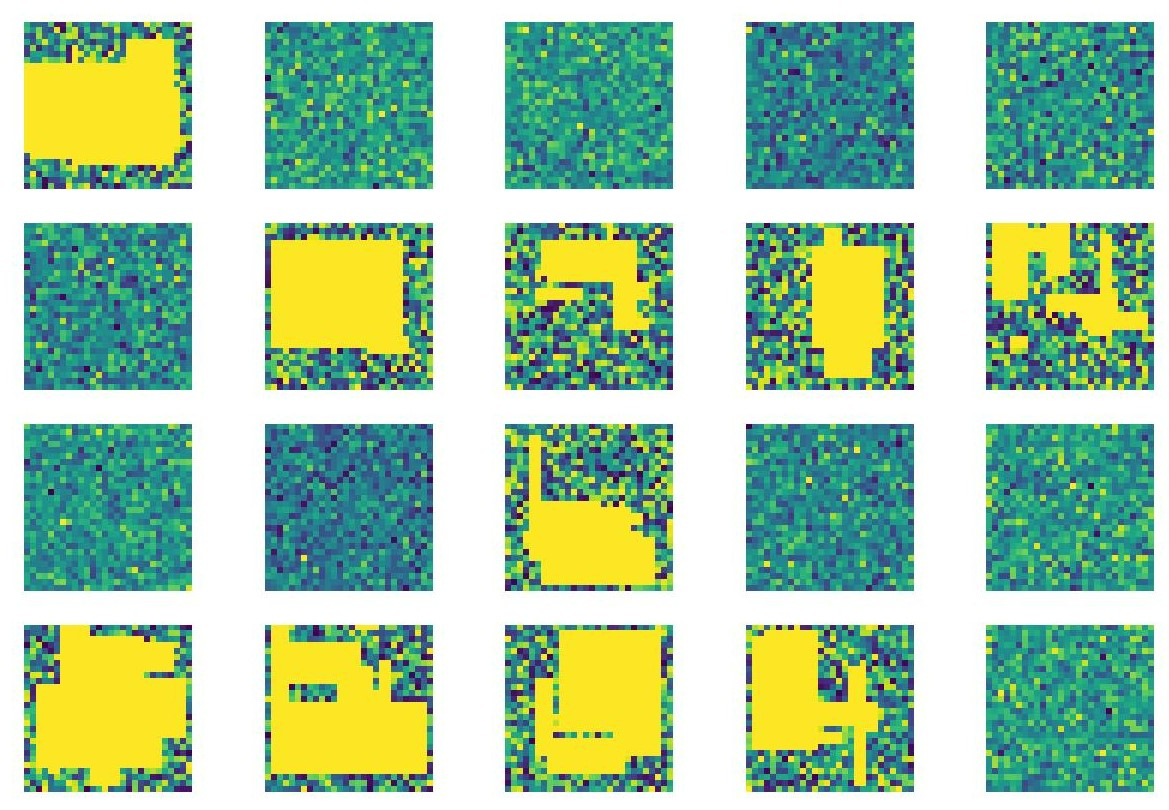

<h1><center>Feded Data</center></h1>

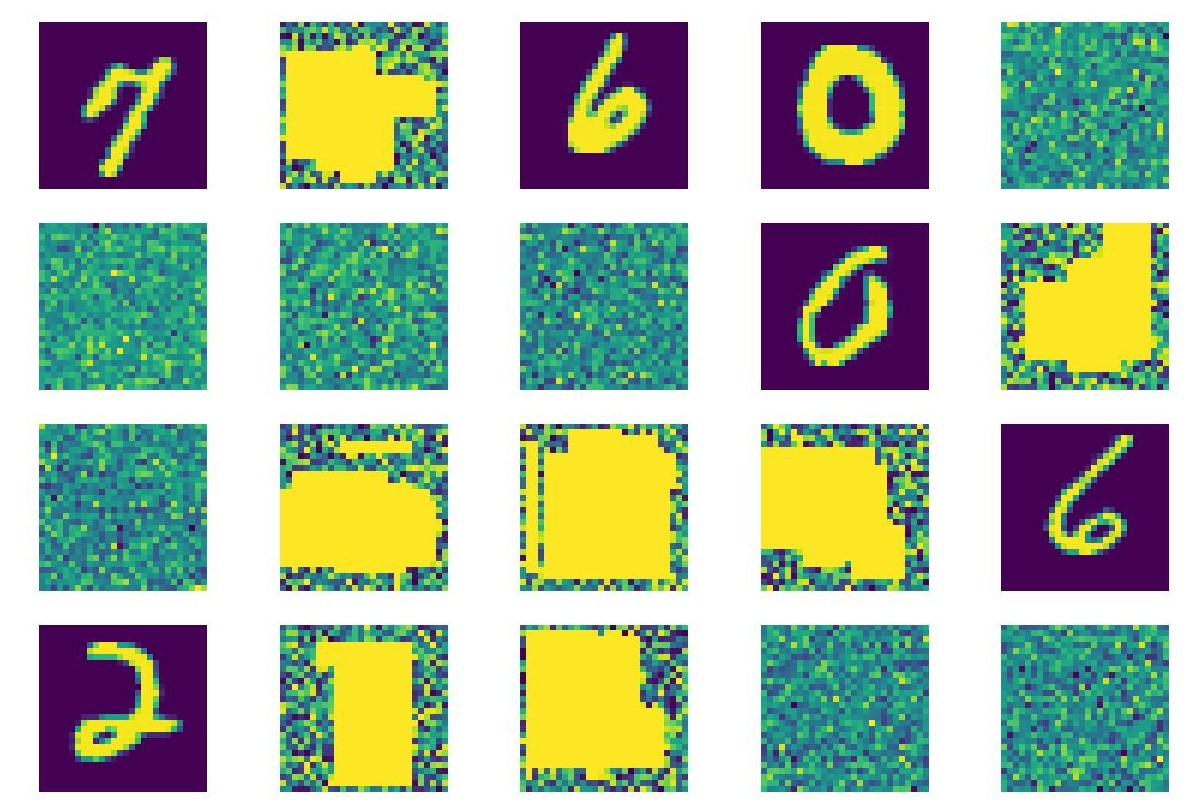

# `Thank You`